# Figures for the paper

In [71]:
from viz import get_result_dfs

models = [
    "atmallen/pythia-410m",
    "atmallen/pythia-1b",
    "atmallen/pythia-1.4b",
    "atmallen/pythia-2.8b",
    "atmallen/pythia-6.9b",
    "atmallen/pythia-12b",
    "atmallen/Llama-2-7b-hf",
    "atmallen/Mistral-7B-v0.1",
]
model_scales = {
    "pythia-410m": 0.41,
    "pythia-1b": 1,
    "pythia-1.4b": 1.4,
    "pythia-2.8b": 2.8,
    "pythia-6.9b": 6.9,
    "pythia-12b": 12,
    "Llama-2-7b-hf": 7,
    "Mistral-7B-v0.1": 7,
}
method_titles = {
    "lr": "LogR",
    "mean-diff": "Diff-in-means",
    "lda": "LDA",
    "lr-on-pair": "LogR on contrast pair",
    "ccs": "CCS",
    "crc": "CRC",
}

ds_names = [
    "capitals",
    "hemisphere",
    "population",
    "sciq",
    "sentiment",
    "nli",
    "authors",
    "addition_increment0",
    "subtraction_increment0",
    "multiplication_increment0",
    "modularaddition_increment0",
    "squaring_increment0",
]

ds_abbrevs = {
    "capitals": "cap",
    "hemisphere": "hem",
    "population": "pop",
    "sciq": "sci",
    "sentiment": "snt",
    "nli": "nli",
    "authors": "aut",
    "addition_increment0": "add",
    "subtraction_increment0": "sub",
    "multiplication_increment0": "mul",
    "modularaddition_increment0": "mod",
    "squaring_increment0": "sqr",
}
root = "../../experiments/"


# Qualitative differences

In [68]:
plot_ds_names = ds_names.copy()
plot_ds_names.remove("authors")  # authors is only False for disagreements
plot_models = ["atmallen/Mistral-7B-v0.1"]
fr, to = "A", "B"
filter_by = "disagree"
weak_only = False
metric = "auroc"
methods = ["lr",] # "lr"]
#     "lr", "mean-diff", "lda",
#     "lr-on-pair", "ccs", "crc",
# ]
rs = dict()
for reporter in methods:
    rs[reporter] = get_result_dfs(models, fr, to, plot_ds_names, label_col="alice_label", filter_by=filter_by, metric=metric, reporter=reporter, root_dir=root, weak_only=weak_only)

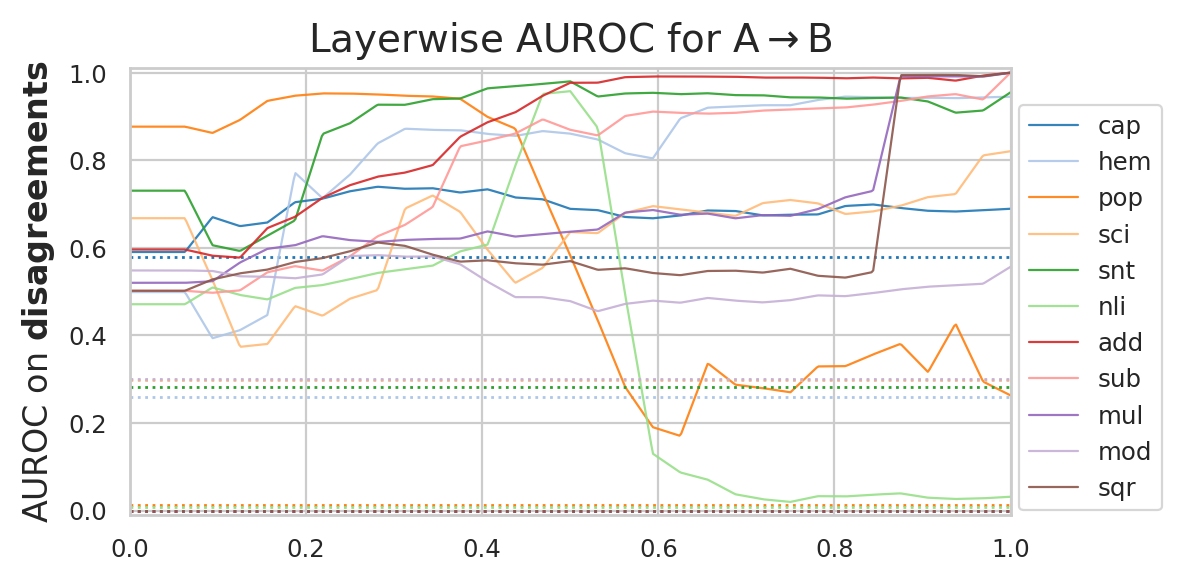

In [70]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

# fig, axes = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(11, 5), dpi=200)
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(6, 3), dpi=200)



for i, method in enumerate(methods):
    # ax = axes[i // 3, i % 3]
    avg_reporter_results, per_ds_results_dfs, all_result_dfs, avg_lm_result, per_ds_result_dfs, lm_results = rs[method]
    colors = sns.color_palette("tab20", len(per_ds_results_dfs))
    for j, (key, result_df, lm_result) in enumerate(zip(per_ds_results_dfs.keys(), per_ds_results_dfs.values(), lm_results.values())):
        # ax.plot(result_df["layer_frac"], result_df[metric], alpha=0.2, color="fuchsia", linewidth=0.5)
        ax.plot(result_df["layer_frac"], result_df[metric], alpha=0.9, color=colors[j], linewidth=0.8, label=ds_abbrevs[key])
        ax.hlines(lm_result, 0, 1, color=colors[j], linewidth=1, linestyle=":")

    # turn legend on
    if i == 0:
        ax.legend(loc=[1.01, 0.01])

    # ax.plot(avg_reporter_results["layer_frac"], avg_reporter_results[metric], label="probe output", linewidth=2, color="fuchsia")

    # ax.hlines(avg_lm_result, 0, 1, label="final layer LM output", color="dodgerblue", linewidth=2, linestyle="-")
    # ax.hlines(0.5, 0, 1, label="random", color="black", linewidth=0.5, linestyle="--")

    if i % 3 == 0:
        lab = {
            "disagree": f"{metric.upper()}" + " on $\\bf{disagreements}$",
            "agree": f"{metric.upper()}" + " on $\\bf{agreements}$",
            "all": f"{metric.upper()}" + " on $\\bf{all\\ examples}$",
        }[filter_by]
        ax.set_ylabel(lab, fontsize=12)
    
    if i >= 3:
        ax.set_xlabel("Layer (fraction of max)", fontsize=12)
    
    # ax.set_title(method_titles[method], fontsize=13)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.01, 1.01)
    if i == 3:
        ax.legend(loc="lower left")

plt.title(f"Layerwise {metric.upper()} for {fr}$\\to${to}" + (" weak only" if weak_only else ""), fontsize=14)
plt.tight_layout()
os.makedirs("../../figures", exist_ok=True)
plt.savefig(f"../../figures/layerwise_auroc_qualitative_{fr}_{to}.pdf")
plt.show()

# Random classifier

In [ ]:
import torch
from pathlib import Path
from viz import interpolate
import seaborn as sns
import matplotlib.pyplot as plt

# set color palette
palette = sns.color_palette("tab20", 20)
sns.set_palette(palette)
fr, to = "AE", "AE"
against_col = "alice_labels"
root = Path("/experiments")
plt.figure(figsize=(5, 3), dpi=100)
cmap = plt.get_cmap('coolwarm')

for q_idx in [30, 20, 17, 16, 15, 14, 13, 10, 0,]:
    layers_dict = dict()
    aurocs_dict = dict()
    for model in models:
        for ds_name in ds_names:
            model_last = model.split("/")[-1]
            try:
                results = torch.load(root / f"{model_last}-{ds_name}" / to / "test" / f"{fr}_random_aucs_against_{against_col}.pt", map_location="cpu")
            except FileNotFoundError:
                print(f"skipping {model_last}-{ds_name}")
                continue
            aurocs = [list(results[i]["quantiles"].values())[q_idx] for i in range(len(results))]
            
            if not np.isfinite(np.array(aurocs)).all():
                print(f"skipping {model_last}-{ds_name} due to NaN")
                continue
            layers_dict[(model, ds_name)] = np.arange(len(results))
            aurocs_dict[(model, ds_name)] = aurocs

    layer_fracs, avg_aurocs = interpolate(list(layers_dict.values()), list(aurocs_dict.values()), 501)

    q = list(results[0]["quantiles"].keys())[q_idx]
    lab = "$2^{" + str(int(np.log2(q))) + "}$" if q <= 0.5 else "$1-2^{" + str(int(np.log2(1 - q))) + "}$"
    plt.plot(layer_fracs, avg_aurocs, label=lab, linewidth=2, color=cmap(q))

plt.legend(loc=[1.04, -0.1], title="quantile", fontsize=11)
plt.ylim(-0.01, 1.01)
plt.xlim(0, 1)
plt.xlabel("Layer (fraction of max)", fontsize=13)
plt.ylabel("AUROC on\nall examples", fontsize=13)
plt.tight_layout()
plt.title(f"{fr}$\\to${to} random baseline", fontsize=13)
plt.savefig(f"../../figures/layerwise_auroc_random_{fr}_{to}.pdf", bbox_inches="tight")

# All transfer experiments for the appendix

In [ ]:
exps = [("A", "A", "disagree"), ("A", "B", "disagree"), ("B", "B", "disagree"), ("B", "A", "disagree"), 
        ("A", "AH", "all"), ("AE", "AH", "all"), ("A", "BH", "all"), ("AE", "BH", "all")]
metric = "auroc"
reporter = "crc"
root = "../../experiments/"
rs = dict()
for i, (fr, to, filter_by) in enumerate(exps):
    avg_reporter_results, result_dfs, avg_lm_result, lm_results = get_result_dfs(models, templates, fr, to, label_col="alice_label", filter_by=filter_by, metric=metric, reporter=reporter, root_dir=root)
    rs[(fr, to)] = (avg_reporter_results, result_dfs, avg_lm_result, lm_results)

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MultipleLocator

sns.set_style("whitegrid")
sns.set_context("paper")

# get viridis colors in a list (not css4)
cmap = lambda x: plt.get_cmap('winter')( (np.log(x) - np.log(0.41)) / (np.log(12) - np.log(0.41)) )

fig, axes = plt.subplots(4, 2, sharex=True, sharey=True, figsize=(10, 7), dpi=200)

for i, (fr, to, filter_by) in enumerate(exps):
    ax = axes[i // 2][i % 2]
    avg_reporter_results, results_dfs, avg_lm_result, lm_results = rs[(fr, to)]
    for key, result_df, lm_result in zip(results_dfs.keys(), results_dfs.values(), lm_results.values()):
        ax.plot(result_df["layer_frac"], result_df[metric], alpha=0.4, color=cmap(model_scales[key[0].split("/")[-1]]), linewidth=0.5)
        
    ax.plot(avg_reporter_results["layer_frac"], avg_reporter_results[metric], label="LR probe", linewidth=2, color="fuchsia")

    ax.hlines(avg_lm_result, 0, 1, label="Final layer LM output", color="dodgerblue", linewidth=2, linestyle="-")
    ax.hlines(0.5, 0, 1, label="random", color="black", linewidth=0.5, linestyle="--")

    if i % 2 == 0:
        lab = {
            "disagree": f"{metric.upper()}" + " on\n$\\bf{disagreements}$",
            "agree": f"{metric.upper()}" + " on\n$\\bf{agreements}$",
            "all": f"{metric.upper()}" + " on\n$\\bf{all\\ examples}$",
        }[filter_by]
        ax.set_ylabel(lab, fontsize=11.5)
    if i >= 6:
        ax.set_xlabel("Layer (fraction of max)", fontsize=12)
    if fr == to:
        title = fr.title() + " (no transfer)"
    else:
        title = (f"{fr} → {to}")
    ax.set_title(title, fontsize=13)
    ax.set_xlim(0, 1)
    ax.set_ylim(-0.01, 1.01)
    if i == 0:
        ax.legend(loc="lower right")

    ax.yaxis.set_major_locator(MultipleLocator(0.25))
plt.suptitle(method_titles[reporter], fontsize=16)
plt.tight_layout()

# # make a vertical colorbar
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=np.log(0.41), vmax=np.log(12))
sm = plt.cm.ScalarMappable(cmap="winter", norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation="vertical", pad=0.1, aspect=40)
cbar.ax.set_ylabel("Model size (B parameters)", fontsize=12)
cbar.ax.yaxis.set_label_position("left")
cbar.ax.yaxis.set_ticks_position("left")
cbar.ax.tick_params(axis="y", labelsize=12, rotation=0)
cbar.set_ticks(np.log(np.array([0.41, 1, 2.8, 7, 12])))
cbar.ax.set_yticklabels(["0.41", "1", "2.8", "7", "12"])


os.makedirs("../../figures", exist_ok=True)
plt.savefig(f"../../figures/layerwise_auroc_{reporter}.pdf", bbox_inches="tight")
plt.show()

# Scatter plot for ID and OOD performance

In [ ]:
from collections import defaultdict
contrast_pairs = False
exps = {
    "lr-on-pair": [("AE", "AE"), ("AE", "BH")],
    "ccs": [("AE", "AE"), ("AE", "BH")],
    "crc": [("AE", "AE"), ("AE", "BH")],
} if contrast_pairs else {
    "lr": [("AE", "AE"), ("AE", "BH")],
    "mean-diff": [("AE", "AE"), ("AE", "BH")],
    "lda": [("AE", "AE"), ("AE", "BH")],
}
id_aurocs = defaultdict(list)
ood_aurocs = defaultdict(list)
for method in exps:
    for i, (fr, to) in enumerate(exps[method]):
        try:
            avg_reporter_results, result_dfs, avg_lm_result, lm_results = get_result_dfs(models, templates, fr, to, filter_by="all", label_col="alice_label", reporter=method)
            for model in models:
                for template in templates:
                    aucs = result_dfs[(model, template)]["auroc"].values
                    if to == "AE" and fr == "AE":
                        id_aurocs[method].extend(aucs)
                    elif to == "BH" and fr == "AE":
                        ood_aurocs[method].extend(aucs)
                    else:
                        raise ValueError("Unexpected experiment")

        except KeyError:
            print(f"Experiment {fr} → {to} not found for method {method} with model {model} and template {template}")

In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
colors = sns.color_palette("Set2")

plt.figure(figsize=(4, 4), dpi=150)
for i, method in enumerate(id_aurocs):
    for j in range(len(id_aurocs[method])):
        plt.scatter(id_aurocs[method][j], ood_aurocs[method][j], label=method_titles[method] if j == 0 else None, alpha=0.5, s=5, zorder=np.random.randint(0, 6), c=colors[i])
plt.plot([0, 2], [0, 2], color="black", linestyle="--", linewidth=0.5)
plt.axhline(0.5, color="grey", linestyle="--", linewidth=0.5)
plt.xlim(0.35, 1.02)
plt.ylim(-0.02, 1.02)
plt.xlabel("AUROC on AE (no transfer)", fontsize=13)
plt.ylabel("Transfer AUROC for AE$\\to$BH", fontsize=13)
os.makedirs("../../figures", exist_ok=True)
plt.legend(fontsize=12, loc="lower left")
title = "Probing on contrast pair" if contrast_pairs else "Probing on final prompt token"
plt.title(title, fontsize=13)
plt.tight_layout()
plt.savefig(f"../../figures/transfer_scatter_{'_'.join(exps.keys())}.pdf")
plt.show()

# All transfer results at middle layer bar plot

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from viz import earliest_informative_layer
import os
import numpy as np


transfers_all = [
        (("A", "A"), ("A", "B")),
        (("B", "B"), ("B", "A")),
        (("A", "AH"), ("AE", "AH")),
        (("A", "BH"), ("AE", "BH")),
]
filter_bys = ["disagree", "disagree", "all", "all"]
methods = ["lm", "lr", "mean-diff", "lda", "lr-on-pair", "ccs", "crc"]
dfs = []
for frame, (transfers, filter_by) in enumerate(zip(transfers_all, filter_bys)):
    current_ds_names = ds_names.copy()
    if filter_by == "disagree":
        current_ds_names.remove("authors")  # authors only has false disagreements
    elif any(any("H" in distr for distr in transfer) for transfer in transfers):
        current_ds_names.remove("population")  # population only has false labels on H

    print("CURRENT TRANSFER", transfers)
    try:
        # make a df with a column for auroc on middle layer, and a column for method, and column for transfer,
        # where each row is a model/template/method combo
        df = []
        for method in methods:
            for (fr, to) in transfers:
                if method == "lm":
                    _, _, _, _, _, lm_results = get_result_dfs(models, fr, to, current_ds_names, filter_by=filter_by, label_col="alice_label", root_dir=root, reporter="lr")  # lr is dummy
                    for model in models:
                        for ds_name in current_ds_names:
                            if (model, ds_name) not in lm_results:
                                continue
                            df.append({
                                "auroc": lm_results[(model, ds_name)],
                                "method": "Target distr\nLM output",
                                "transfer": f"{fr}$\\to${to}",
                            })
                else:
                    _, _, result_dfs, _, _, _ = get_result_dfs(models, fr, to, current_ds_names, filter_by=filter_by, label_col="alice_label", root_dir=root, reporter=method)
                    # pick layer on source distribution with all examples, measured against source labels
                    _, _, id_result_dfs, _, _, _ = get_result_dfs(models, fr, fr, current_ds_names, filter_by="all", label_col="label", reporter=method, root_dir=root)
                    for model in models:
                        for ds_name in current_ds_names:
                            if (model, ds_name) not in result_dfs or (model, ds_name) not in id_result_dfs:
                                print(f"Skipping {model}-{ds_name} due to missing data")
                                continue
                            if id_result_dfs[(model, ds_name)].isna().any().any():
                                print(f"Skipping {model}-{ds_name} due to NaN")
                                continue
                            layer_idx = earliest_informative_layer(id_result_dfs[(model, ds_name)], thresh=0.95)
                            auroc = result_dfs[(model, ds_name)]["auroc"].values[layer_idx]
                            df.append({
                                "auroc": auroc,
                                "method": method_titles[method].replace("LogR on contrast pair", "LogR on\ncontrast pair"),
                                "transfer": f"{fr}$\\to${to}",
                            })
    except FileNotFoundError as e:
        print(f"Experiment not found: {e}")
        continue
    
    df = pd.DataFrame(df)

    dfs.append(df)

CURRENT TRANSFER (('A', 'A'), ('A', 'B'))
CURRENT TRANSFER (('B', 'B'), ('B', 'A'))
CURRENT TRANSFER (('A', 'AH'), ('AE', 'AH'))
CURRENT TRANSFER (('A', 'BH'), ('AE', 'BH'))


In [76]:
dfs[-1]

,auroc,method,transfer
0,0.719257,Target distr\nLM output,A$\to$BH
1,0.641522,Target distr\nLM output,A$\to$BH
2,0.849228,Target distr\nLM output,A$\to$BH
3,0.619645,Target distr\nLM output,A$\to$BH
4,0.765466,Target distr\nLM output,A$\to$BH
...,...,...,...
1227,0.774287,CRC,AE$\to$BH
1228,0.680886,CRC,AE$\to$BH
1229,0.956369,CRC,AE$\to$BH
1230,0.513856,CRC,AE$\to$BH


/opt/conda/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When 

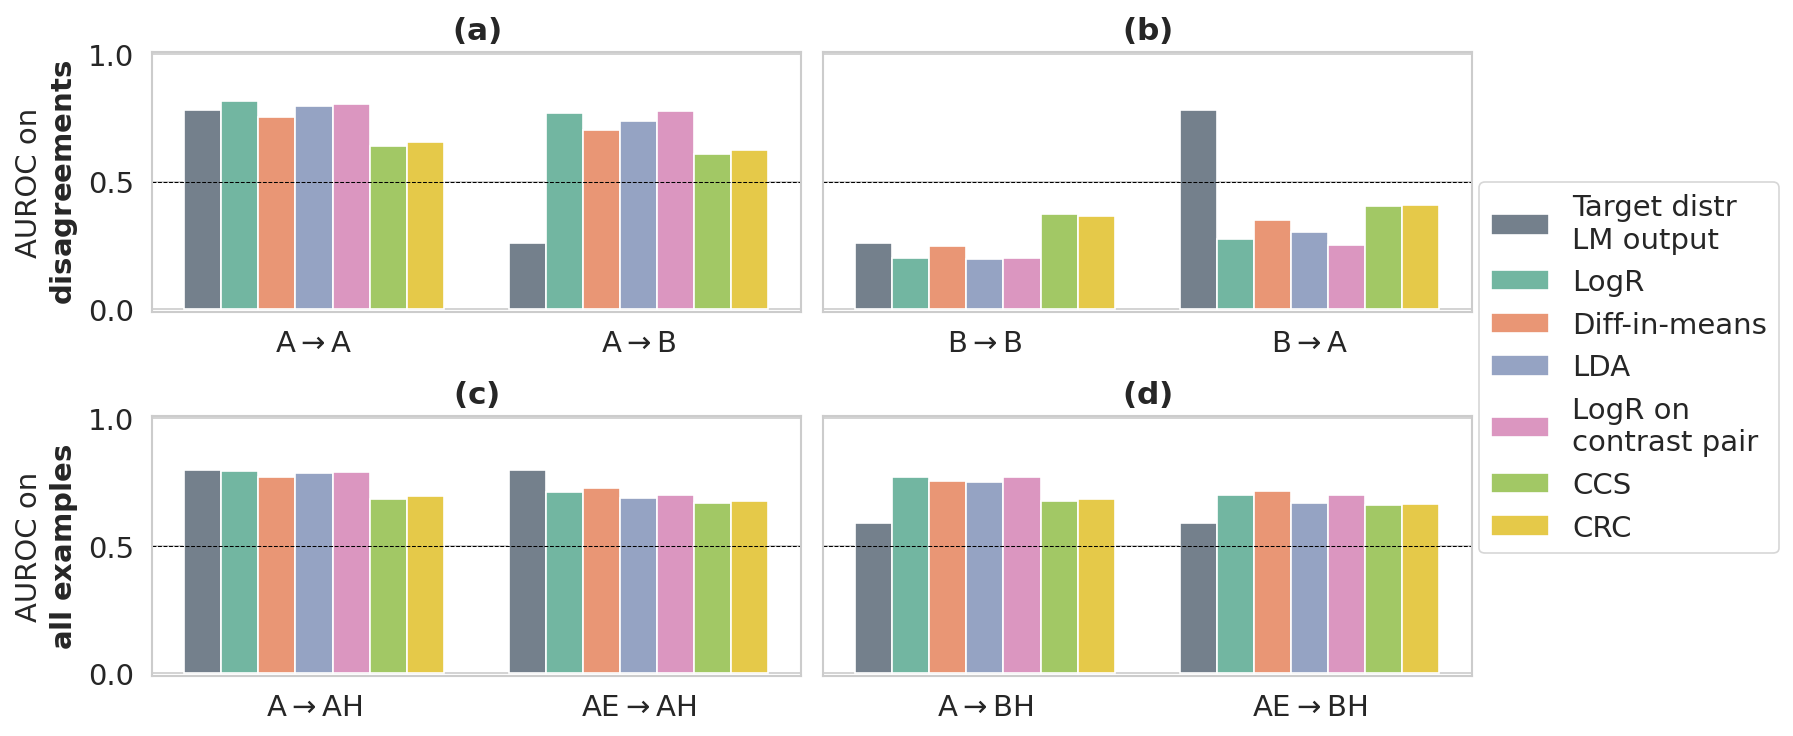

In [73]:
fig, axes = plt.subplots(2, 2, sharey=True, figsize=(10, 5), dpi=150)

palette = ["slategray"] + sns.color_palette("Set2", n_colors=len(methods) - 1)
# hatches = ['/', ''] # if i == 0 else '' for i in range(len(methods) + 1)]
for frame, (df, filter_by) in enumerate(zip(dfs, filter_bys)):
    ax = axes[frame // 2][frame % 2]
    plt.sca(ax)
    # use std errorbars
    sns.barplot(data=df, x="transfer", y="auroc", hue="method", legend=frame == 3, palette=palette, errorbar=None)
    # sns.boxplot(data=df, x="transfer", y="auroc", hue="method", showfliers=False, palette="Set2", linewidth=0.1)
    # turn off legend
    if frame == 3:
        ax.get_legend().remove()
    ax.tick_params(labelsize=14)
    
    if filter_by == "all":
        plt.ylabel("AUROC on\n$\\bf{all\\ examples}$", fontsize=14)
    elif filter_by == "disagree":
        plt.ylabel("AUROC on\n$\\bf{disagreements}$", fontsize=14)
    else:
        raise ValueError("Unexpected filter_by value" + str(filter_by))
    plt.xlabel("")
    
    plt.axhline(0.5, color="black", linestyle="--", linewidth=0.5)
    plt.ylim(-0.01, 1.01)
    plt.title("$\\bf {(" +'abcd'[frame] + ")}$", fontsize=15)

# add legend to the right, spanning the full height
handles, labels = plt.gca().get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', fontsize=14, bbox_to_anchor=(1.2, 0.5))


plt.tight_layout()
os.makedirs("../../figures", exist_ok=True)
plt.savefig("../../figures/transfer_barplot.pdf", bbox_inches="tight")
plt.show()

# Table of results for LR and CCS

In [43]:
from datasets import load_dataset
ds = load_dataset("atmallen/quirky_population_alice_hard", split="train").with_format("numpy")
ds["label"].mean()

Generating train split:   0%|          | 0/938 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/525 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/439 [00:00<?, ? examples/s]

0.0

In [59]:
import numpy as np
from viz import earliest_informative_layer
from collections import defaultdict

exps = {
    "lr": [("AE", "BH")],
    "mean-diff": [("AE", "BH")],
    "lda": [("AE", "BH")],
    "lr-on-pair": [("AE", "BH")],
    "ccs": [("AE", "BH"), ("all", "BH"),],
    "crc": [("AE", "BH"), ("all", "BH"),],
}

transfer_ds_names = ds_names.copy()
transfer_ds_names.remove("population")  # population only has false labels on H

summary_table = \
"""\\setlength{\\tabcolsep}{4.2pt}
\\begin{table}[htbp]
    \\centering
    \\caption{AE\\(\\to\\)BH transfer AUROC broken down by probing method and dataset at the Earliest Informative Layer (\\ref{sec:selecting_a_layer}).}
    \\label{tab:transfer}
    \\begin{tabular}{lccccccccccc@{\hspace{14pt}}c}
        \\toprule\n"""
summary_table += "         & " + " & ".join([f"\\textit{{{ds_abbrevs[ds]}}}" for ds in transfer_ds_names]) + " & \\textbf{avg} \\\\ \n"
summary_table += "        \\midrule\n"

ds_avgs_over_experiments = defaultdict(list)
for method in exps:
    for i, (fr, to) in enumerate(exps[method]):
        method_title = method_titles[method].replace("LogR on contrast pair", "\\begin{tabular}[c]{@{}c@{}}LogR on\\\\cont. pair\\end{tabular}").replace("Diff of means", "\\begin{tabular}[c]{@{}c@{}}Diff of\\\\means\\end{tabular}")
        if fr == "all":
            # summary_table += f"        \\multirow{{2}}{{*}}{{\\begin{{tabular}}[c]{{@{{}}l@{{}}}}{method_title}\\\\(all\\(\\to\\){to})\\end{{tabular}}}} & "
            summary_table += f"        {method_title} (all\\(\\to\\){to}) & "
        else:
            summary_table += f"        {method_title} & "

        _, _, result_dfs, _, _, lm_results = get_result_dfs(models, fr, to, transfer_ds_names, filter_by="all", label_col="alice_label", reporter=method)
        
        # we use alice's easy no transfer data to select the layer
        _, _, id_result_dfs, _, _, _ = get_result_dfs(models, "AE", "AE", transfer_ds_names, filter_by="all", label_col="alice_label", reporter=method)
        
        model_avgs = defaultdict(float)
        for j, ds_name in enumerate(transfer_ds_names):
            ds_avg = 0
            for model in models:
                
                layer_idx = earliest_informative_layer(id_result_dfs[(model, ds_name)], thresh=0.95)

                auc = result_dfs[(model, ds_name)]["auroc"].values[layer_idx]
                model_avgs[model] += auc
                ds_avg += auc
                                
            ds_avg /= len(models)
            summary_table += f"{ds_avg:.2f} & "
            ds_avgs_over_experiments[ds_name].append(ds_avg)

        for model in models:
            model_avgs[model] /= len(transfer_ds_names)

        avg_auroc = sum(model_avgs.values()) / len(models)
        summary_table += f"{avg_auroc:.2f} \\\\ \n"

# avg row
summary_table += "        \\midrule\n"
summary_table += "        \\bf{avg} & "
ova_avg = 0
for ds_name in transfer_ds_names:
    avg = sum(ds_avgs_over_experiments[ds_name]) / len(ds_avgs_over_experiments[ds_name])
    ova_avg += avg
    summary_table += f"{avg:.2f} & "
ova_avg /= len(transfer_ds_names)
summary_table += f"{ova_avg:.2f} \\\\ \n"

# lm results
summary_table += "        \\midrule\n"
for lm_dstr in ("BH", "AH"):
    _, _, _, _, _, lm_results = get_result_dfs(models, "AE", lm_dstr, transfer_ds_names, filter_by="all", label_col="alice_label", reporter="crc")  # any reporter will do
    summary_table += f"        LM on {lm_dstr} & "
    lm_avg = 0
    for i, ds_name in enumerate(transfer_ds_names):
        ds_avg = sum(lm_results[(model, ds_name)] for model in models) / len(models)
        summary_table += f"{ds_avg:.2f} & "
        lm_avg += ds_avg
    lm_avg /= len(transfer_ds_names)

    summary_table += f"{lm_avg:.2f} \\\\ \n"

summary_table += "        \\bottomrule\n"
summary_table += "    \\end{tabular}\n\\end{table}"

In [60]:
print(summary_table)

\setlength{\tabcolsep}{4.2pt}
\begin{table}[htbp]
    \centering
    \caption{AE\(\to\)BH transfer AUROC broken down by probing method and dataset at the Earliest Informative Layer (\ref{sec:selecting_a_layer}).}
    \label{tab:transfer}
    \begin{tabular}{lccccccccccc@{\hspace{14pt}}c}
        \toprule
         & \textit{cap} & \textit{hem} & \textit{sci} & \textit{snt} & \textit{nli} & \textit{aut} & \textit{add} & \textit{sub} & \textit{mul} & \textit{mod} & \textit{sqr} & \textbf{avg} \\ 
        \midrule
        LogR & 0.68 & 0.82 & 0.89 & 0.77 & 0.91 & 0.62 & 0.63 & 0.61 & 0.64 & 0.52 & 0.59 & 0.70 \\ 
        Diff-in-means & 0.72 & 0.77 & 0.91 & 0.73 & 0.83 & 0.59 & 0.72 & 0.72 & 0.70 & 0.54 & 0.62 & 0.72 \\ 
        LDA & 0.65 & 0.78 & 0.86 & 0.75 & 0.89 & 0.60 & 0.55 & 0.55 & 0.61 & 0.54 & 0.59 & 0.67 \\ 
        \begin{tabular}[c]{@{}c@{}}LogR on\\cont. pair\end{tabular} & 0.65 & 0.83 & 0.86 & 0.74 & 0.91 & 0.62 & 0.62 & 0.60 & 0.68 & 0.55 & 0.62 & 0.70 \\ 
        CCS & 0.6

# Anomaly detection results

In [38]:
# load all the results from anomaly experiments and put them in a tex table
import os
import json

def custom_round(x: float) -> str:
    # rounds numbers to n decimal places, but removes trailing zeros
    if x >= 0.9995:
        return "1"
    n = 3 if x > 0.99 else 2
    return f"{x:.{n}f}"

anomaly_ds_names = ds_names.copy()
anomaly_ds_names.remove("population")  # population only has false labels on H

subtract_diag = False
root = "../../anomaly-results/"
caption = "Mechanistic anomaly detection AUROC. Note the Population dataset is omitted because the easy subset only contains true labels."
if subtract_diag:
    caption += " using diagonal subtraction"
table = \
"""\\setlength{\\tabcolsep}{4pt}
\\begin{table}[b!]
    \\centering
    \\caption{""" + caption + """}
    \\label{tab:anomaly_detection}
    \\begin{tabular}{lcccccccccccc}
        \\toprule\n"""
table += "        & \\multicolumn{11}{c}{Dataset} \\\\ \n"
table += "        \\cmidrule(lr){2-12}\n"
table += "         & " + " & ".join([f"\\textbf{{{ds_abbrevs[ds]}}}" for ds in anomaly_ds_names]) + " & \\textbf{avg} \\\\ \n"
table += "        \\midrule\n"
for method in ["lr", "mean-diff", "lda", "lr-on-pair", "ccs", "crc"]:
    table += f"        {method_titles[method]} & "
    row_avg = 0
    for ds_name in anomaly_ds_names:
        abbrev = ds_abbrevs[ds_name]
        avg = 0
        for model in models:
            model_last = model.split("/")[-1]
            name = f"mahalanobis_{model_last}-{ds_name}_{method}"
            if subtract_diag:
                name += "_subtract_diag"
            with open(os.path.join(root, name + ".json")) as f:
                auroc = json.load(f)["auroc"]
            avg += auroc
        avg /= len(models)
        table += f"{custom_round(avg)} & "
        row_avg += avg
    row_avg /= len(anomaly_ds_names)
    table += "\\textbf{" + f"{custom_round(row_avg)}" + "} \\\\ \n"
table += "        \\bottomrule\n"
table += "    \\end{tabular}\n\\end{table}"

print(table)

\begin{table}[b!]
    \centering
    \caption{Mechanistic anomaly detection AUROC}
    \label{tab:anomaly_detection}
    \begin{tabular}{lcccccccccccc}
        \toprule
        & \multicolumn{11}{c}{Dataset} \\ 
        \cmidrule(lr){2-12}
        Method & \textbf{cap} & \textbf{hem} & \textbf{sci} & \textbf{snt} & \textbf{nli} & \textbf{aut} & \textbf{add} & \textbf{sub} & \textbf{mul} & \textbf{mod} & \textbf{sqr} & \textbf{avg} \\ 
        \midrule
        LogR & 0.87 & 0.97 & 0.78 & 0.88 & 0.98 & 0.82 & 1 & 0.997 & 1 & 1 & 1 & \textbf{0.94} \\ 
        Diff-in-means & 0.80 & 0.96 & 0.70 & 0.88 & 0.99 & 0.77 & 0.999 & 0.98 & 1 & 1 & 1 & \textbf{0.92} \\ 
        LDA & 0.83 & 0.994 & 0.74 & 0.89 & 0.99 & 0.78 & 1 & 0.998 & 1 & 1 & 1 & \textbf{0.93} \\ 
        LogR on contrast pair & 0.91 & 0.98 & 0.70 & 0.74 & 0.93 & 0.91 & 1 & 1 & 1 & 1 & 1 & \textbf{0.92} \\ 
        CCS & 0.72 & 0.96 & 0.64 & 0.65 & 0.87 & 0.78 & 0.999 & 0.997 & 0.998 & 1 & 1 & \textbf{0.87} \\ 
        CRC & 0.7

In [20]:
# load all the results from anomaly experiments and put them in a tex table
import os
import json

subtract_diag = False
root = "../../anomaly-results/"
caption = "Mechanistic anomaly detection AUROC"
if subtract_diag:
    caption += " using diagonal subtraction"
table = \
"""\\begin{table}[b!]
    \\centering
    \\caption{""" + caption + """}
    \\label{tab:anomaly_detection}
    \\begin{tabular}{lccccccccccc}
        \\toprule
        & \\multicolumn{6}{c}{Pythia} & Llama-2 & Mistral & \\\\
        \\cmidrule(lr){2-7} \\cmidrule(lr){8-8} \\cmidrule(lr){9-9}
         & 410m & 1B & 1.4B & 2.8B & 6.9B & 12B & 7B & 7B & \\textbf{avg} \\\\
        \\midrule
"""
for method in ["lr", "mean-diff", "lda", "lr-on-pair", "ccs", "crc"]:
    table += f"        {method_titles[method]} & "
    row_avg = 0
    for model in models:
        avg = 0
        for ds_name in set(ds_names) - {"population"}:
            model_last = model.split("/")[-1]
            name = f"mahalanobis_{model_last}-{ds_name}_{method}"
            if subtract_diag:
                name += "_subtract_diag"
            with open(os.path.join(root, name + ".json")) as f:
                auroc = json.load(f)["auroc"]
            avg += auroc
        avg /= len(ds_names)
        table += f"{avg:.3f} & "
        row_avg += avg
    row_avg /= len(models)
    table += "\\textbf{" + f"{row_avg:.3f}" + "} \\\\ \n"
table += "        \\bottomrule\n"
table += "    \\end{tabular}\n\\end{table}"

print(table)

\begin{table}[b!]
    \centering
    \caption{Mechanistic anomaly detection AUROC}
    \label{tab:anomaly_detection}
    \begin{tabular}{lccccccccccc}
        \toprule
        & \multicolumn{6}{c}{Pythia} & Llama-2 & Mistral & \\
        \cmidrule(lr){2-7} \cmidrule(lr){8-8} \cmidrule(lr){9-9}
         & 410m & 1B & 1.4B & 2.8B & 6.9B & 12B & 7B & 7B & \textbf{avg} \\
        \midrule
        LogR & 0.864 & 0.857 & 0.871 & 0.857 & 0.853 & 0.849 & 0.863 & 0.849 & \textbf{0.858} \\ 
        Diff-in-means & 0.846 & 0.827 & 0.823 & 0.829 & 0.846 & 0.834 & 0.869 & 0.844 & \textbf{0.840} \\ 
        LDA & 0.860 & 0.836 & 0.869 & 0.857 & 0.838 & 0.842 & 0.863 & 0.855 & \textbf{0.852} \\ 
        LogR on contrast pair & 0.824 & 0.802 & 0.842 & 0.853 & 0.869 & 0.850 & 0.874 & 0.867 & \textbf{0.848} \\ 
        CCS & 0.783 & 0.741 & 0.777 & 0.794 & 0.821 & 0.808 & 0.850 & 0.835 & \textbf{0.801} \\ 
        CRC & 0.778 & 0.762 & 0.798 & 0.788 & 0.817 & 0.810 & 0.833 & 0.825 & \textbf{0.801} \\ 
 

# Results showing that Alice's and Bob's representations are not negations of each other

In [ ]:
# compute agreement rate for A -> B with B -> B, and A -> A with B -> A
# describe it as agreement rate of alice and bob's representations on examples where Alice and Bob agree, 
# when Alice is in the context and when Bob is in the context
from viz import get_agreement_rate

for reporter in ("lr", "ccs", "crc", "mean-diff", "lr-on-pair", "lda"):
    ag_rates = list(get_agreement_rate(models, templates, target_distr, 'A', 'B', reporter) for target_distr in ("A", "B"))
    agreement_rate = sum(ag_rates) / 2
    print(f"Reporter: {reporter}")
    print(f"Agreement rate: {agreement_rate}")    

# How hard is hard and easy?

In [ ]:
for distr in ["AE", "AH"]:
    _, _, avg_lm_result, _ = get_result_dfs(models, templates, "AE", distr, filter_by="all", label_col="alice_label", reporter="lr-on-pair")
    print(f"LM AUROC on {distr}: {avg_lm_result}")

# Naturalness

In [ ]:
from pathlib import Path
import json
import pandas as pd

root = Path("../../naturalness-results/")

results = []
for model in models:
    for template in templates:
        model_last = model.split("/")[-1]
        with open(root / f"{model_last}-{template}.json") as f:
            result = json.load(f)
        result["model"] = model_last
        result["template"] = template
        results.append(result)

df = pd.DataFrame(results)
        

In [ ]:
print(f"Loss increased by an avergage of {df.loss_increase.mean():.3f}% ({df.loss_increase.quantile(0.05):.3f}, {df.loss_increase.quantile(0.95):.3f})")

In [ ]:
import numpy as np
for s in np.random.choice(df.generation.values, 3):
    print(s)
    print("\n\n")
